In [1]:
import datetime
import os
import copy
import sys
import csv
import random
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from tqdm import tqdm
import pickle
from statistics import mean
from scipy.stats import pearsonr # 科学技術計算ライブラリ
from PIL import Image
import statistics

/home/taki/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 論文用図作成


### 属性情報を用いた際の図作成

In [2]:
### conditional 選択
conditional = 1

In [3]:
dir = f'/home/taki/bento_conditional/log/BEST_conditional_{conditional}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
out_df_list   = []
score_df_list = []


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

for cv_num in range(5):
    out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
    score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
    out_dir   = dir + out_dir
    score_dir = dir + score_dir

    out_df = pd.read_csv(out_dir)
    score_df = pd.read_csv(score_dir)

    out_df_list.append(out_df)
    score_df_list.append(score_df)

out_df = out_df_list[0]
score_df = score_df_list[0]
for i in range(len(out_df_list)-1):
    out_df = pd.concat([out_df,out_df_list[i+1]])
    score_df = pd.concat([score_df,score_df_list[i+1]])

out_df = out_df.drop("Unnamed: 0",axis=1)
score_df = score_df.drop("Unnamed: 0",axis=1)

col_list = {}
for i in range(len(col)):
    col_list[f"{i}"] = col[i]
out_df = out_df.rename(columns=col_list)
out_df = out_df.reset_index(drop=True)
score_df = score_df.rename(columns=col_list)
score_df = score_df.reset_index(drop=True)

for i in range(0,5):
    out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
    score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)
    out_df_list[i] = out_df_list[i].rename(columns=col_list)
    out_df_list[i] = out_df_list[i].reset_index(drop=True)
    score_df_list[i] = score_df_list[i].rename(columns=col_list)
    score_df_list[i] = score_df_list[i].reset_index(drop=True)


## mae_df 作成

In [5]:
corr_list = []
p_list = []
mae_df_list = []
for idx in range(0,5):
    #print(f"~~~~~~~~~~K={idx}~~~~~~~~~~~~~~~~~~~")
    corr_tmp = []
    p_tmp = []
    mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
    for i in range(len(col)):
        
        
        #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
        a, b = pearsonr(score_df_list[idx][col[i]], out_df_list[idx][col[i]]) # リストを整形し相関係数:aとp値:bの計算
        #print("相関係数:", a)
        #print("p値:", b)
        corr_tmp.append(a)
        p_tmp.append(b)
    corr_list.append(corr_tmp)
    p_list.append(p_tmp)

for idx in range(5):
    print(idx)
    img_mae_list = []
    all_mae_list = []
    sum_mae_list = []

    for i in range(len(mae_df_list[idx])):
        img_mae_list.append(mae_df_list[idx].loc[i].mean())
        all_mae_list.append(mae_df_list[idx].loc[i].mean())
        sum_mae_list.append(mae_df_list[idx].loc[i].sum())
    mae_df_list[idx]["sum_mae"] = sum_mae_list
    mae_df_list[idx]["img_mae"] = img_mae_list
    print(np.mean(img_mae_list),"±",np.std(img_mae_list))


# 結合
mae_df = pd.concat([mae_df_list[0],mae_df_list[1]])
for i in range(2,5):
    mae_df = pd.concat([mae_df,mae_df_list[i]])
mae_df = mae_df.reset_index(drop=True)
mae_df

0
0.09388009146714285 ± 0.042248475684370304
1
0.08761366525 ± 0.03774243349682779
2
0.085465575040201 ± 0.04091778024035311
3
0.09580170068126347 ± 0.04238352664182224
4
0.09157164094185209 ± 0.03672614554877638


,color,healthy,satisfaction,uniqueness,ease of eating,appropriate amount,not collapse,sum_mae,img_mae
0,0.215600,0.014613,0.005801,0.249332,0.227916,0.057271,0.006516,0.777049,0.111007
1,0.021251,0.134053,0.065445,0.213909,0.078836,0.059614,0.093613,0.666721,0.095246
2,0.246571,0.349320,0.274610,0.068688,0.137806,0.001302,0.332941,1.411238,0.201605
3,0.174820,0.195805,0.047437,0.127634,0.112340,0.134459,0.070470,0.862964,0.123281
4,0.196320,0.052824,0.047897,0.174681,0.112299,0.170510,0.112833,0.867365,0.123909
...,...,...,...,...,...,...,...,...,...
992,0.237128,0.003991,0.072889,0.195501,0.151740,0.001329,0.113781,0.776359,0.110908
993,0.227760,0.224815,0.166001,0.219371,0.131225,0.251899,0.068434,1.289504,0.184215
994,0.071680,0.013221,0.019899,0.207344,0.064907,0.045780,0.260746,0.683577,0.097654
995,0.014999,0.034260,0.045996,0.169641,0.081637,0.070777,0.141215,0.558525,0.079789


In [7]:
len(corr_list[0])

7

## 誤差が少ない画像選択

In [76]:


k0_df =  mae_df_list[0]
small_list2 = k0_df["sum_mae"].nsmallest(20)
large_list2 = k0_df["sum_mae"].nlargest(10)

test_index_df = pd.read_csv(f"/home/taki/bento_conditional/log/BEST_conditional_{conditional}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid0/testdata_index.csv")
attribute_df = pd.read_csv(f"/home/taki/bento_conditional/log/BEST_conditional_{conditional}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid0/attribute_df.csv")

# 画像選択
for i in range(len(small_list2)):
    # 上位何番目か
    img_name = test_index_df["path"][small_list2.keys()[i]]
    print(img_name)
    # test dataに男女のデータあるか確認
    print(test_index_df.index[test_index_df['path'] == img_name])
    #print("")

tomoko (26).jpg
Int64Index([187], dtype='int64')
wappakun (68).jpg
Int64Index([119, 193], dtype='int64')
nagae_bento (4).jpg
Int64Index([5, 36], dtype='int64')
makiwappa  (124).jpg
Int64Index([17, 53], dtype='int64')
r__obento (39).jpg
Int64Index([94], dtype='int64')
tomoko (2).jpg
Int64Index([145], dtype='int64')
uco (33).jpg
Int64Index([108], dtype='int64')
aknms (27).jpg
Int64Index([35, 55], dtype='int64')
sora (65).jpg
Int64Index([14, 112], dtype='int64')
hitorigohan (235).jpg
Int64Index([67, 156], dtype='int64')
nagae_bento (75).jpg
Int64Index([166, 199], dtype='int64')
makiwappa  (94).jpg
Int64Index([136], dtype='int64')
cookgram  (32).jpg
Int64Index([93, 122], dtype='int64')
tomoko (80).jpg
Int64Index([20, 170], dtype='int64')
m_bookcook (118).jpg
Int64Index([22, 152], dtype='int64')
naoben (48).jpg
Int64Index([9, 175], dtype='int64')
tomoko (80).jpg
Int64Index([20, 170], dtype='int64')
m_bookcook (108).jpg
Int64Index([10, 158], dtype='int64')
hitorigohan (185).jpg
Int64Index([3

In [63]:
img_list = ["wappakun (68).jpg"]
img_iloc_list = test_index_df.index[test_index_df['path'] == img_list[0]]
for img_iloc in img_iloc_list:
    print(img_iloc)
    print(attribute_df.iloc[img_iloc])


119
Unnamed: 0    119.0
0               0.0
1               1.0
Name: 119, dtype: float64
193
Unnamed: 0    193.0
0               1.0
1               0.0
Name: 193, dtype: float64


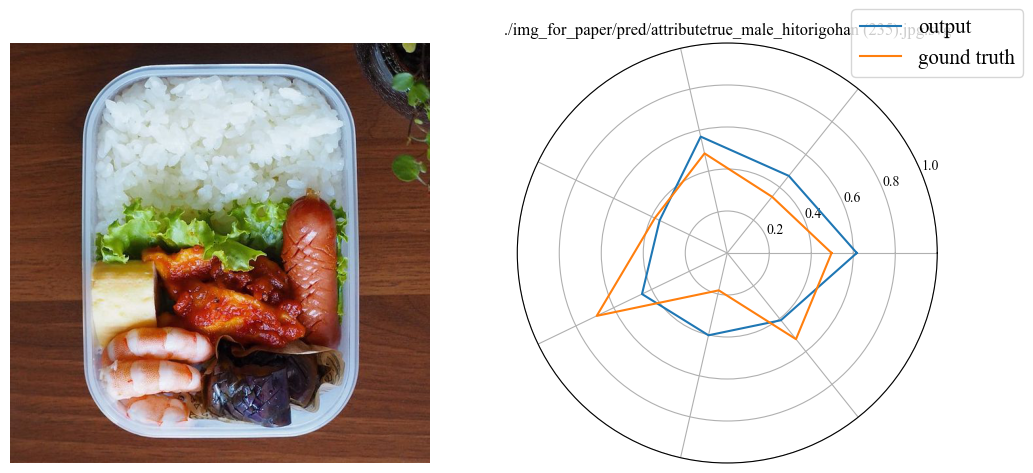

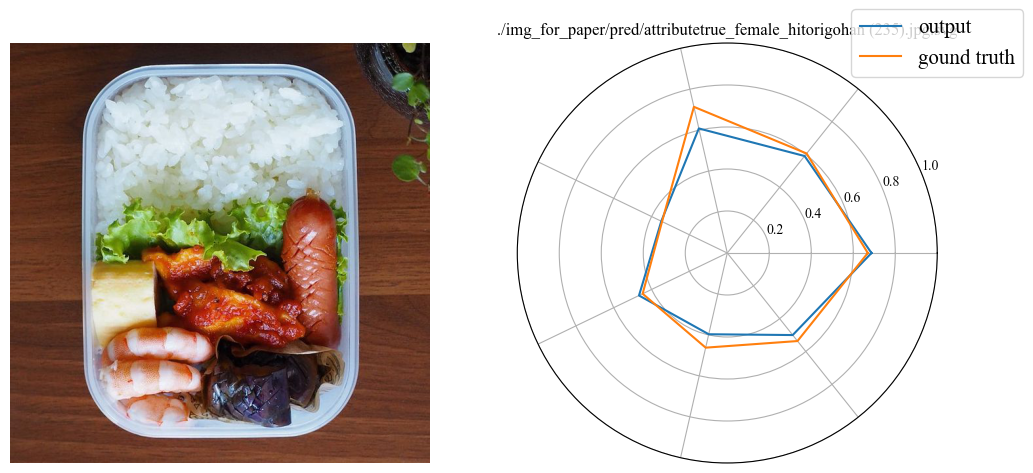

In [77]:
# レーダーチャート表示
k0_df =  mae_df_list[0]
small_list2 = k0_df["sum_mae"].nsmallest(10)
large_list2 = k0_df["sum_mae"].nlargest(10)


img_list = ["hitorigohan (235).jpg"]
img_iloc_list = test_index_df.index[test_index_df['path'] == img_list[0]]


if conditional == 1:
    attribute_flg = "true"
else:
    attribute_flg = 0

for img_iloc in img_iloc_list:

    if attribute_df.iloc[img_iloc]["0"]==1:
        sex = "male"
    else:
        sex = "female"
    
    if sex == "male":
        sex_flg = 0
    else:
        sex_flg = 1




    test_index_df = pd.read_csv(f"/home/taki/bento_conditional/log/BEST_conditional_{conditional}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid0/testdata_index.csv")
    attribute_df = pd.read_csv(f"/home/taki/bento_conditional/log/BEST_conditional_{conditional}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid0/attribute_df.csv")

    col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]
    col = ["","","","","","",""]

    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    df = pd.read_csv("./male_female_factor_score.csv")


    for img_val in img_list:

        img_idx = df.index[df["path"] == img_val]
        img_path = os.path.join(data_dir,df.iloc[img_idx[0]]["path"])

        img = Image.open(img_path)

        # 多角形を閉じるためにデータの最後に最初の値を追加する。
        output_values = np.append(out_df_list[0].iloc[img_iloc].values, out_df_list[0].iloc[img_iloc].values[0])
        score_values  = np.append(df.loc[img_idx[sex_flg]]["factor1":"factor7"], df.loc[img_idx[sex_flg]]["factor1":"factor7"][0])

        # プロットする角度を生成する。
        angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

        plt.rcParams['font.family']='Times New Roman'

        fig = plt.figure(figsize=(12, 12))

        # libのmatplotのファイルのデフォルトフォントを変えた
        #plt.rcParams['font.family'] = 'IPAexGothic'
        #print(plt.rcParams["font.family"])
        #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
        ax0 = fig.add_subplot(2, 2, 1)
        ax1 = fig.add_subplot(2, 2, 2, polar=True)

        #img_path = data_dir +  img_name[index_list[i]]
        #ax0.imshow(mpimg.imread(img_path))
        ax0.axis("off")
        ax0.imshow(img)
        #ax0.set_title(img_path[index_list[i]], pad=20)


        # 極座標でaxを作成。
        # レーダーチャートの線を引く
        ax1.plot(angles, output_values, label="output")
        ax1.plot(angles, score_values, label="gound truth")

        # 項目ラベルの表示
        ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col,fontname="Times New Roman", fontsize=15)
        ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

        ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0,fontsize=15)
        tmp = img_val.split()[1].split(".")[0]
        plt.title(f"./img_for_paper/pred/attribute{attribute_flg}_{sex}_{img_val}.svg")
        #plt.savefig(f"./img_for_paper/pred/attribute_{attribute_flg}_{sex}_{img_val}.svg")#, transparent=True)
        #plt.title(img_val)
        #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)

        #plt.savefig(f"./img_for_paper/pred/attribute{attribute_flg}_{sex}.svg")#, transparent=True)
        plt.show()
        #img_path = save_path +  f"/closs_valid{cv_num}_{i}.png"
        #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{large_list2[idx]}.svg"






        plt.clf() # 図全体をクリア
        plt.cla() # 軸をクリア
        plt.close('all') # closes all the figure windows



### 属性情報を用いない際の図作成

## 散布図プロット、男女別

In [ ]:
attribute_flg = 1 # 1:use 0:not use

In [12]:
attribute_flg = 1 # 1:use 0:not use
dir = f'/home/taki/bento_conditional/log/BEST_conditional_{attribute_flg}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
out_df_list   = []
score_df_list = []
attribute_df_list = []


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

for cv_num in range(5):
    out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
    score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
    attribute_dir = f"/closs_valid{cv_num}/attribute_df.csv"
    out_dir   = dir + out_dir
    score_dir = dir + score_dir
    attribute_dir = dir + attribute_dir

    out_df = pd.read_csv(out_dir)
    score_df = pd.read_csv(score_dir)
    attribute_df = pd.read_csv(attribute_dir)

    out_df_list.append(out_df)
    score_df_list.append(score_df)
    attribute_df_list.append(attribute_df)

out_df = out_df_list[0]
score_df = score_df_list[0]
attribute_df = attribute_df_list[0]

for i in range(len(out_df_list)-1):
    out_df = pd.concat([out_df,out_df_list[i+1]])
    score_df = pd.concat([score_df,score_df_list[i+1]])
    attribute_df = pd.concat([attribute_df,attribute_df_list[i+1]])

out_df = out_df.drop("Unnamed: 0",axis=1)
score_df = score_df.drop("Unnamed: 0",axis=1)
attribute_df = attribute_df.drop("Unnamed: 0",axis=1)

col_list = {}
for i in range(len(col)):
    col_list[f"{i}"] = col[i]
out_df = out_df.rename(columns=col_list)
out_df = out_df.reset_index(drop=True)
score_df = score_df.rename(columns=col_list)
score_df = score_df.reset_index(drop=True)

attribute_df = attribute_df.reset_index(drop=True)

for i in range(0,5):
    out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
    score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)
    out_df_list[i] = out_df_list[i].rename(columns=col_list)
    out_df_list[i] = out_df_list[i].reset_index(drop=True)
    score_df_list[i] = score_df_list[i].rename(columns=col_list)
    score_df_list[i] = score_df_list[i].reset_index(drop=True)
    attribute_df_list[i] = attribute_df_list[i].reset_index(drop=True)

corr_list = []
p_list = []
mae_df_list = []
for idx in range(0,5):
    #print(f"~~~~~~~~~~K={idx}~~~~~~~~~~~~~~~~~~~")
    corr_tmp = []
    p_tmp = []
    mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
    for i in range(len(col)):
        
        
        #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
        a, b = pearsonr(score_df_list[idx][col[i]], out_df_list[idx][col[i]]) # リストを整形し相関係数:aとp値:bの計算
        #print("相関係数:", a)a
        #print("p値:", b)
        corr_tmp.append(a)
        p_tmp.append(b)
    corr_list.append(corr_tmp)
    p_list.append(p_tmp)

# 男女別結果確認

In [ ]:
attribute_flg = 1 # 1:use 0:not use
dir = f'/home/taki/bento_conditional/log/BEST_conditional_{attribute_flg}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
out_df_list   = []
score_df_list = []
attribute_df_list = []


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

for cv_num in range(5):
    out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
    score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
    attribute_dir = f"/closs_valid{cv_num}/attribute_df.csv"
    out_dir   = dir + out_dir
    score_dir = dir + score_dir
    attribute_dir = dir + attribute_dir

    out_df = pd.read_csv(out_dir)
    score_df = pd.read_csv(score_dir)
    attribute_df = pd.read_csv(attribute_dir)

    out_df_list.append(out_df)
    score_df_list.append(score_df)
    attribute_df_list.append(attribute_df)

out_df = out_df_list[0]
score_df = score_df_list[0]
attribute_df = attribute_df_list[0]

for i in range(len(out_df_list)-1):
    out_df = pd.concat([out_df,out_df_list[i+1]])
    score_df = pd.concat([score_df,score_df_list[i+1]])
    attribute_df = pd.concat([attribute_df,attribute_df_list[i+1]])

out_df = out_df.drop("Unnamed: 0",axis=1)
score_df = score_df.drop("Unnamed: 0",axis=1)
attribute_df = attribute_df.drop("Unnamed: 0",axis=1)

col_list = {}
for i in range(len(col)):
    col_list[f"{i}"] = col[i]
out_df = out_df.rename(columns=col_list)
out_df = out_df.reset_index(drop=True)
score_df = score_df.rename(columns=col_list)
score_df = score_df.reset_index(drop=True)

attribute_df = attribute_df.reset_index(drop=True)

for i in range(0,5):
    out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
    score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)
    out_df_list[i] = out_df_list[i].rename(columns=col_list)
    out_df_list[i] = out_df_list[i].reset_index(drop=True)
    score_df_list[i] = score_df_list[i].rename(columns=col_list)
    score_df_list[i] = score_df_list[i].reset_index(drop=True)
    attribute_df_list[i] = attribute_df_list[i].reset_index(drop=True)

corr_list = []
p_list = []
mae_df_list = []
for idx in range(0,5):
    #print(f"~~~~~~~~~~K={idx}~~~~~~~~~~~~~~~~~~~")
    corr_tmp = []
    p_tmp = []
    mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
    for i in range(len(col)):
        
        
        #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
        a, b = pearsonr(score_df_list[idx][col[i]], out_df_list[idx][col[i]]) # リストを整形し相関係数:aとp値:bの計算
        #print("相関係数:", a)a
        #print("p値:", b)
        corr_tmp.append(a)
        p_tmp.append(b)
    corr_list.append(corr_tmp)
    p_list.append(p_tmp)

In [21]:
# 交差検証ごとの男女別結果を出す
male_corr_list = []
female_corr_list = []
p_list = []
male_mae_df_list = []
female_mae_df_list = []

for idx in range(0,5):
    # 男女別のデータ定義
    male_index = attribute_df_list[idx].index[attribute_df_list[idx]["0"] == 1]
    female_out_df = out_df_list[idx].drop(male_index)
    female_score_df = score_df_list[idx].drop(male_index)

    female_index = attribute_df_list[idx].index[attribute_df_list[idx]["1"] == 1]
    male_out_df = out_df_list[idx].drop(female_index)
    male_score_df = score_df_list[idx].drop(female_index)

    male_corr_tmp = []
    female_corr_tmp = []
    #p_tmp = []
    male_mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
    female_mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))

    for i in range(len(col)):
        
        
        #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
        male_a, male_b = pearsonr(male_score_df[col[i]], male_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
        #print("相関係数:", a)
        #print("p値:", b)
        male_corr_tmp.append(male_a)
        #p_tmp.append(b)

        female_a, female_b = pearsonr(female_score_df[col[i]], female_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
        female_corr_tmp.append(female_a)

    male_corr_list.append(male_corr_tmp)
    female_corr_list.append(female_corr_tmp)
    #p_list.append(p_tmp)

In [23]:
male_corr_df = pd.DataFrame(male_corr_list)
print("男性の結果")
for i in range(7):
    print(f"{col[i]}:{male_corr_df.mean()[i].round(6)}±{male_corr_df.std()[i].round(6)}")

男性の結果
color:0.729269±0.025881
healthy:0.57537±0.036827
satisfaction:0.562936±0.070767
uniqueness:0.593051±0.06543
ease of eating:0.512644±0.047621
appropriate amount:0.212428±0.077405
not collapse:0.297343±0.084452


In [24]:
female_corr_df = pd.DataFrame(female_corr_list)
print("女性の結果")
for i in range(7):
    print(f"{col[i]}:{female_corr_df.mean()[i].round(6)}±{female_corr_df.std()[i].round(6)}")

女性の結果
color:0.586734±0.041385
healthy:0.473093±0.096144
satisfaction:0.480918±0.022967
uniqueness:0.461073±0.121575
ease of eating:0.495973±0.083725
appropriate amount:0.313415±0.106322
not collapse:0.337154±0.043379


### 関数化したやつ（男女別結果）

In [47]:
attribute_flg = 1 # 1:use 0:not use
def print_attribute_result(attribute_flg):
    if attribute_flg == 1:
        print("属性情報を使った結果")
    else:
        print("属性情報を使っていない結果")
    dir = f'/home/taki/bento_conditional/log/BEST_conditional_{attribute_flg}_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
    out_df_list   = []
    score_df_list = []
    attribute_df_list = []


    col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

    for cv_num in range(5):
        out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
        score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
        attribute_dir = f"/closs_valid{cv_num}/attribute_df.csv"
        out_dir   = dir + out_dir
        score_dir = dir + score_dir
        attribute_dir = dir + attribute_dir

        out_df = pd.read_csv(out_dir)
        score_df = pd.read_csv(score_dir)
        attribute_df = pd.read_csv(attribute_dir)

        out_df_list.append(out_df)
        score_df_list.append(score_df)
        attribute_df_list.append(attribute_df)

    out_df = out_df_list[0]
    score_df = score_df_list[0]
    attribute_df = attribute_df_list[0]

    for i in range(len(out_df_list)-1):
        out_df = pd.concat([out_df,out_df_list[i+1]])
        score_df = pd.concat([score_df,score_df_list[i+1]])
        attribute_df = pd.concat([attribute_df,attribute_df_list[i+1]])

    out_df = out_df.drop("Unnamed: 0",axis=1)
    score_df = score_df.drop("Unnamed: 0",axis=1)
    attribute_df = attribute_df.drop("Unnamed: 0",axis=1)

    col_list = {}
    for i in range(len(col)):
        col_list[f"{i}"] = col[i]
    out_df = out_df.rename(columns=col_list)
    out_df = out_df.reset_index(drop=True)
    score_df = score_df.rename(columns=col_list)
    score_df = score_df.reset_index(drop=True)

    attribute_df = attribute_df.reset_index(drop=True)

    for i in range(0,5):
        out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
        score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)
        out_df_list[i] = out_df_list[i].rename(columns=col_list)
        out_df_list[i] = out_df_list[i].reset_index(drop=True)
        score_df_list[i] = score_df_list[i].rename(columns=col_list)
        score_df_list[i] = score_df_list[i].reset_index(drop=True)
        attribute_df_list[i] = attribute_df_list[i].reset_index(drop=True)

    corr_list = []
    p_list = []
    mae_df_list = []
    for idx in range(0,5):
        #print(f"~~~~~~~~~~K={idx}~~~~~~~~~~~~~~~~~~~")
        corr_tmp = []
        p_tmp = []
        mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
        for i in range(len(col)):
            
            
            #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
            a, b = pearsonr(score_df_list[idx][col[i]], out_df_list[idx][col[i]]) # リストを整形し相関係数:aとp値:bの計算
            #print("相関係数:", a)a
            #print("p値:", b)
            corr_tmp.append(a)
            p_tmp.append(b)
        corr_list.append(corr_tmp)
        p_list.append(p_tmp)


    # 交差検証ごとの男女別結果を出す
    male_corr_list = []
    female_corr_list = []
    p_list = []
    male_mae_df_list = []
    female_mae_df_list = []

    for idx in range(0,5):
        # 男女別のデータ定義
        male_index = attribute_df_list[idx].index[attribute_df_list[idx]["0"] == 1]
        female_out_df = out_df_list[idx].drop(male_index)
        female_score_df = score_df_list[idx].drop(male_index)

        female_index = attribute_df_list[idx].index[attribute_df_list[idx]["1"] == 1]
        male_out_df = out_df_list[idx].drop(female_index)
        male_score_df = score_df_list[idx].drop(female_index)

        male_corr_tmp = []
        female_corr_tmp = []
        #p_tmp = []
        male_mae_df_list.append(abs(male_out_df-male_score_df))
        female_mae_df_list.append(abs(female_out_df-female_score_df))

        for i in range(len(col)):
            
            
            #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
            male_a, male_b = pearsonr(male_score_df[col[i]], male_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
            #print("相関係数:", a)
            #print("p値:", b)
            male_corr_tmp.append(male_a)
            #p_tmp.append(b)

            female_a, female_b = pearsonr(female_score_df[col[i]], female_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
            female_corr_tmp.append(female_a)

        male_corr_list.append(male_corr_tmp)
        female_corr_list.append(female_corr_tmp)
        #p_list.append(p_tmp)

    ### corr #####
    male_corr_df = pd.DataFrame(male_corr_list)
    print("男性の結果")
    print("corr")
    for i in range(7):
        print(f"{col[i]}:{male_corr_df.mean()[i].round(6)}±{male_corr_df.std()[i].round(6)}")
    
    #### MAE ######
    print("")
    print("MAE")
    male_mae_df = pd.concat([male_mae_df_list[0],male_mae_df_list[1]])
    for i in range(2,5):
        male_mae_df = pd.concat([male_mae_df,male_mae_df_list[i]])
    male_mae_df = male_mae_df.reset_index(drop=True)
    for i in range(len(col)):
        print(f"{col[i]}:",male_mae_df[col[i]].mean().round(6),"±",male_mae_df[col[i]].std().round(6))

    print("")
    ### corr #####
    female_corr_df = pd.DataFrame(female_corr_list)
    print("女性の結果")
    print("corr")
    for i in range(7):
        print(f"{col[i]}:{female_corr_df.mean()[i].round(6)}±{female_corr_df.std()[i].round(6)}")

    #### MAE ######
    print("")
    print("MAE")
    female_mae_df = pd.concat([female_mae_df_list[0],female_mae_df_list[1]])
    for i in range(2,5):
        female_mae_df = pd.concat([female_mae_df,female_mae_df_list[i]])
    female_mae_df = female_mae_df.reset_index(drop=True)
    for i in range(len(col)):
        print(f"{col[i]}:",female_mae_df[col[i]].mean().round(6),"±",female_mae_df[col[i]].std().round(6))
    

In [48]:
print_attribute_result(1)

属性情報を使った結果
男性の結果
corr
color:0.729269±0.025881
healthy:0.57537±0.036827
satisfaction:0.562936±0.070767
uniqueness:0.593051±0.06543
ease of eating:0.512644±0.047621
appropriate amount:0.212428±0.077405
not collapse:0.297343±0.084452

MAE
color: 0.087446 ± 0.065234
healthy: 0.097678 ± 0.076356
satisfaction: 0.097316 ± 0.076116
uniqueness: 0.106225 ± 0.084326
ease of eating: 0.088792 ± 0.071743
appropriate amount: 0.104843 ± 0.079939
not collapse: 0.100637 ± 0.07696

女性の結果
corr
color:0.586734±0.041385
healthy:0.473093±0.096144
satisfaction:0.480918±0.022967
uniqueness:0.461073±0.121575
ease of eating:0.495973±0.083725
appropriate amount:0.313415±0.106322
not collapse:0.337154±0.043379

MAE
color: 0.09734 ± 0.080818
healthy: 0.081656 ± 0.069218
satisfaction: 0.071787 ± 0.061169
uniqueness: 0.108227 ± 0.086505
ease of eating: 0.067473 ± 0.055681
appropriate amount: 0.082697 ± 0.072776
not collapse: 0.082483 ± 0.06877


In [49]:
print_attribute_result(0)

属性情報を使っていない結果
男性の結果
corr
color:0.732988±0.030563
healthy:0.566411±0.058557
satisfaction:0.574061±0.045976
uniqueness:0.585973±0.084598
ease of eating:0.551957±0.052804
appropriate amount:0.203071±0.076526
not collapse:0.297219±0.11788

MAE
color: 0.090476 ± 0.068422
healthy: 0.117056 ± 0.082887
satisfaction: 0.098437 ± 0.074766
uniqueness: 0.107969 ± 0.084307
ease of eating: 0.084208 ± 0.069619
appropriate amount: 0.103743 ± 0.082799
not collapse: 0.114345 ± 0.086828

女性の結果
corr
color:0.582006±0.037758
healthy:0.454839±0.097882
satisfaction:0.453263±0.029518
uniqueness:0.496679±0.110729
ease of eating:0.488191±0.086679
appropriate amount:0.300723±0.125636
not collapse:0.356504±0.056859

MAE
color: 0.109292 ± 0.084499
healthy: 0.09174 ± 0.072888
satisfaction: 0.07235 ± 0.064277
uniqueness: 0.105538 ± 0.085936
ease of eating: 0.067018 ± 0.057377
appropriate amount: 0.084366 ± 0.075158
not collapse: 0.096539 ± 0.073979


In [18]:
# 男が欲しい場合は女のインデックスをdrop
male_index = attribute_df.index[attribute_df["0"] == 1]
female_out_df = out_df.drop(male_index)
female_score_df = score_df.drop(male_index)

female_index = attribute_df.index[attribute_df["1"] == 1]
male_out_df = out_df.drop(female_index)
male_score_df = score_df.drop(female_index)

In [11]:
male_out_df


,color,healthy,satisfaction,uniqueness,ease of eating,appropriate amount,not collapse
0,0.255412,0.719012,0.669227,0.473809,0.571947,0.453824,0.461194
4,0.528533,0.426852,0.653898,0.294179,0.541500,0.423829,0.376366
5,0.510361,0.456624,0.481683,0.347804,0.442444,0.435346,0.379462
6,0.543384,0.603257,0.704080,0.238275,0.462414,0.455822,0.425706
7,0.509847,0.548606,0.677784,0.371471,0.421687,0.475537,0.421356
...,...,...,...,...,...,...,...
974,0.567037,0.451574,0.567254,0.579519,0.462924,0.416985,0.342391
989,0.533678,0.346906,0.536409,0.413466,0.676127,0.366300,0.464643
990,0.721021,0.508153,0.381889,0.224562,0.410905,0.372128,0.375161
991,0.556476,0.474008,0.538126,0.364336,0.405190,0.434946,0.316481


appropriate amount


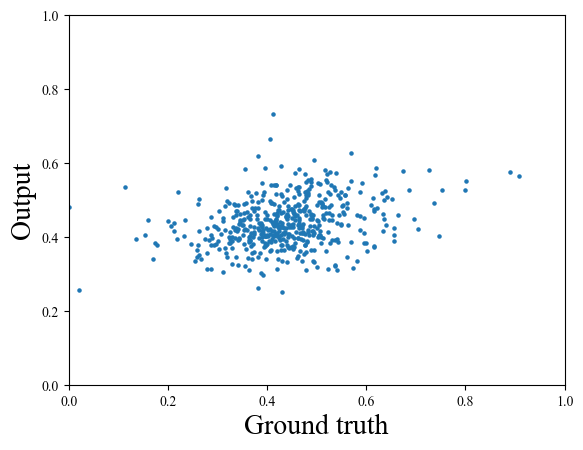

corr= 0.2953625065919065
相関係数: 0.29536250659190666
p値: 9.123817060301982e-12


In [106]:
mae_df = abs(out_df-score_df)
save_path = '/home/taki/bento_conditional/img_for_paper'

i = 5 # not collasp
fig = plt.figure()
plt.scatter(female_score_df[col[i]],
            female_out_df[col[i]],
            label=col[i],s=5)
print(col[i])
#plt.title("corr_score to output")
plt.xlabel("Ground truth",fontsize=20,fontname="Times New Roman")
plt.ylabel("Output",fontsize=20,fontname="Times New Roman")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.savefig(save_path+f"/female_corr_{col[i]}.svg")
plt.show()

#plt.clf() # 図全体をクリア
#plt.cla() # 軸をクリア
#plt.close('all') # closes all the figure windows
print("corr=",np.corrcoef(female_score_df[col[i]],female_out_df[col[i]])[0,1])
#print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
a, b = pearsonr(female_score_df[col[i]], female_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
print("相関係数:", a)
print("p値:", b)

appropriate amount


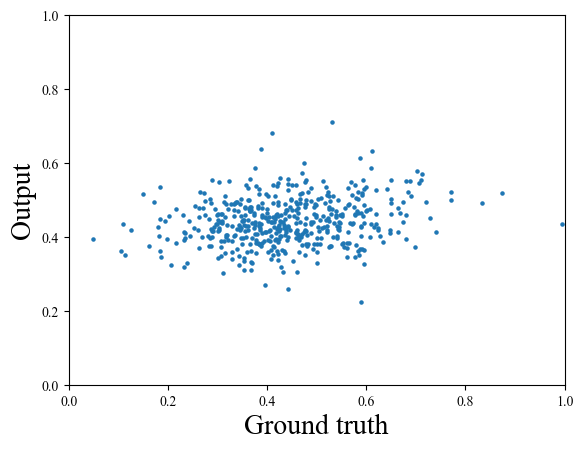

corr= 0.2953625065919065
相関係数: 0.29536250659190666
p値: 9.123817060301982e-12


In [105]:
mae_df = abs(out_df-score_df)
save_path = '/home/taki/bento_conditional/img_for_paper'


fig = plt.figure()
plt.scatter(male_score_df[col[i]],
            male_out_df[col[i]],
            label=col[i],s=5)
print(col[i])
            
#plt.title("corr_score to output")
plt.xlabel("Ground truth",fontsize=20,fontname="Times New Roman")
plt.ylabel("Output",fontsize=20,fontname="Times New Roman")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.savefig(save_path+f"/male_corr_{col[i]}.svg")
plt.show()

#plt.clf() # 図全体をクリア
#plt.cla() # 軸をクリア
#plt.close('all') # closes all the figure windows
print("corr=",np.corrcoef(female_score_df[col[i]],female_out_df[col[i]])[0,1])
#print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
a, b = pearsonr(female_score_df[col[i]], female_out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
print("相関係数:", a)
print("p値:", b)

## see_score

In [2]:
score_df = pd.read_csv("./score_ml_promax_7.csv")
score_df

,path,factor1,factor2,factor3,factor4,factor5,factor6,factor7
0,11n24y (10).jpg,0.626011,0.512187,0.667759,0.278341,0.679017,0.644536,0.385473
1,11n24y (15).jpg,0.418966,0.577724,0.472596,0.154524,0.519459,0.653625,0.461815
2,11n24y (20).jpg,0.544230,0.482227,0.734638,0.268911,0.674837,0.755683,0.368004
3,11n24y (22).jpg,0.434133,0.684328,0.324193,0.268570,0.467308,0.839506,0.470191
4,11n24y (24).jpg,0.478149,0.539188,0.227575,0.338072,0.437760,0.667763,0.355663
...,...,...,...,...,...,...,...,...
995,yumben (57).jpg,0.649259,0.649115,0.638141,0.379576,0.643529,0.731639,0.363457
996,yumben (58).jpg,0.405739,0.364467,0.716503,0.342739,0.554483,0.523175,0.407680
997,yumben (59).jpg,0.453467,0.285186,0.835852,0.285848,0.391417,0.458061,0.253789
998,yumben (60).jpg,0.717414,0.582687,0.548351,0.454048,0.435609,0.778868,0.589075


In [23]:
from ipywidgets import interact


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]
score_mean = score_df.mean(axis=1)
@interact(k=(0,len(score_df.index)-1))

def plot_factor6(k):
    
    print(k)
    k = score_mean.nlargest(1000).index[k]
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"

    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + score_df["path"][k]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(score_df.loc[k][1:], score_df.loc[k][1])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(score_df["path"][k])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=499, description='k', max=999), Output()), _dom_classes=('widget-interac…

In [3]:
len(score_df.index)

1000

In [9]:
score_values  = np.append(score_df.loc[1][1:], score_df.loc[1][1])
score_values

array([0.41896572200000004, 0.577723592, 0.472596426, 0.154524153,
       0.519459486, 0.653625227, 0.46181526100000003, 0.41896572200000004],
      dtype=object)

In [8]:
score_df.loc[0][1:]

factor1    0.626011
factor2    0.512187
factor3    0.667759
factor4    0.278341
factor5    0.679017
factor6    0.644536
factor7    0.385473
Name: 0, dtype: object

In [7]:
score_df.loc[1][1]

0.41896572200000004

In [24]:
score_mean = score_df.mean(axis=1)

In [25]:

score_mean.nlargest(1000).index


Int64Index([231, 237, 814, 739,  76, 238, 249, 306, 242, 625,
            ...
            193, 770, 822, 176, 468, 142,   7, 562, 475, 262],
           dtype='int64', length=1000)

In [27]:
#上位10枚
score_mean.nlargest(1000).index[:10]

Int64Index([231, 237, 814, 739, 76, 238, 249, 306, 242, 625], dtype='int64')

In [31]:
#下位10枚
score_mean.nlargest(1000).index[-10:]

Int64Index([193, 770, 822, 176, 468, 142, 7, 562, 475, 262], dtype='int64')

In [29]:
score_df.iloc[231]

path       hitorigohan (159).jpg
factor1                 0.913357
factor2                 0.940826
factor3                 0.829081
factor4                 0.726713
factor5                 0.906996
factor6                 0.728772
factor7                  0.64702
Name: 231, dtype: object

In [33]:
#真ん中10枚
score_mean.nlargest(1000).index[495:505]

Int64Index([353, 803, 416, 335, 208, 77, 759, 795, 146, 914], dtype='int64')

In [39]:
print("上位10枚")
for i in score_mean.nlargest(1000).index[:10]:
    print(score_df.iloc[i]["path"])

print("中位10枚")
for i in score_mean.nlargest(1000).index[495:505]:
    print(score_df.iloc[i]["path"])

print("下位10枚")
for i in score_mean.nlargest(1000).index[-10:]:
    print(score_df.iloc[i]["path"])

上位10枚
hitorigohan (159).jpg
hitorigohan (181).jpg
tomoko (63).jpg
toco (39).jpg
aknms (64).jpg
hitorigohan (184).jpg
hitorigohan (204).jpg
makiwappa  (5).jpg
hitorigohan (193).jpg
rikioku (9).jpg
中位10枚
miiko (2).jpg
tomoko (41).jpg
m_bookcook (50).jpg
meme (11).jpg
hikameshi (52).jpg
aknms (66).jpg
toco (73).jpg
tomoko (18).jpg
cookgram  (21).jpg
user_nakami  (59).jpg
下位10枚
hikameshi (23).jpg
tomoko (118).jpg
tomoko (83).jpg
cookgram  (98).jpg
nagae_bento (17).jpg
cookgram  (196).jpg
11n24y (29).jpg
onaka__suita (15).jpg
nagae_bento (30).jpg
hitorigohan (34).jpg
